In [1]:
import so3g
import numpy as np
import g3_utils as ut
import matplotlib.pyplot as plt
from spt3g import core
from spt3g.core import G3Units as gu
import pathlib
from astropy.coordinates import SkyCoord

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

stage_file = lambda i: str(control_computer_g3_dir / f"mapmaking/pipeline/stage{i}.g3")

In [3]:
kid_rejects = [11, 21, 57, 81, 111, 127, 147, 148, 149, 150, 151, 152, 154, 158, 170, 181, 182, 192, 195,
              211, 223, 225, 245, 263, 282, 286, 293, 297, 319, 327, 331, 333, 334, 336, 337, 340, 341, 349, 352]
exclude_kids = [ut.kid_string(reject_id, roach_id=1) for reject_id in kid_rejects]

In [4]:
stats = ut.DetectorStats(data_key="df")

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
# create non-normalized df & save
pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data", exclude_kids=exclude_kids)
pipe.Add(ut.AddScanDF, exclude_kids=exclude_kids)
pipe.Add(core.G3Writer, filename=stage_file(1))
# compute medians & standard deviation for each detector scan
pipe.Add(stats)
pipe.Run()

detector_medians = np.median(np.array(stats.medians), axis=0)
detector_stds = np.median(np.array(stats.stds), axis=0)

In [5]:
# TODO: move towards object-oriented approach, maybe using spt3g.maps FlatSkyMap?
source = SkyCoord.from_name('RCW92')
map_args = {
    'ra0': source.icrs.ra.deg * core.G3Units.deg,
    'dec0': source.icrs.dec.deg * core.G3Units.deg,
    'xlen': 4 * core.G3Units.deg,
    'ylen': 4 * core.G3Units.deg,
    'res': 1 * core.G3Units.arcmin,
}

In [6]:
class MapBinner:
    """
    G3 Pipeline Module.
    Bins detectors' TODs (time-ordered-data) into a flat sky map with Plate-Carree projection,
    combining signal from multiple detectors.
    """
    def __init__(self, timestreams="df",
                 ra0: float=None, dec0: float=None,
                 xlen: float=None, ylen: float=None, res: float=None,
                 stds: dict=None, select_kids: list[str] = None):
        """
        Create a new MapBinner.
        :param timestreams: Key into detector G3SuperTimestream for scan frames
        :param ra0: G3Units angle - center of map in right ascension
        :param dec0: G3Units angle - center of map in declination
        :param xlen: G3Units angle - width of map in right ascension
        :param ylen: G3Units angle - height of map in declination
        :param res: G3Units angle - size of map square pixels
        :param stds: Mapping from detector identifiers (^roach[1-5]_\d{4}$) to detector signal standard deviation.
                     Detectors are weighted by 1/σ² when combining maps. If `None` (default), weights maps equally.
        :param select_kids: Optional, list of kids to include in combined map. If `None` (default), all kids are included.
        """
        self.timestreams = timestreams
        self.stds = stds
        assert ra0 is not None, "must set ra0!"
        assert dec0 is not None, "must set dec0!"

        self.ra0 = ra0
        self.dec0 = dec0
        self.xlen = xlen if xlen is not None else 1 * core.G3Units.deg
        self.ylen = ylen if ylen is not None else 1 * core.G3Units.deg
        self.res = res if res is not None else 1 * core.G3Units.arcmin
        # number of bins along each axis
        self.nx = int(self.xlen / self.res)
        self.ny = int(self.ylen / self.res)
        # bin edges
        self.ra_edges = np.linspace(-self.xlen / 2, self.xlen / 2, self.nx + 1) + self.ra0
        self.dec_edges = np.linspace(-self.ylen / 2, self.ylen / 2, self.ny + 1) + self.dec0

        self.select_kids = select_kids

        self.calframe = None
        self._kid_shifts = None

        # array for storing the binned timestream data
        self.data = np.zeros((self.ny, self.nx), dtype=float)
        # array for storing the number of times each pixel is "hit" in the timestreams
        self.hits = np.zeros((self.ny, self.nx), dtype=float)

    def _get_kids(self, ts_names: list[str]) -> list[str]:
        """Determine the list of kids which should contribute to the map

        Returned KIDs exisit in both:
        - detector timestream data
        - select_kids, if provided

        :param ts_names: List of detector names in G3SuperTimestream
        """
        if self.select_kids is None: return ts_names
        return list(set(ts_names).intersection(set(self.select_kids)))

    def _get_kid_shifts(self):
        if self._kid_shifts is not None:
            return self._kid_shifts
        kid_shifts = {}
        kids = np.sort(self.calframe["ra_shifts"].keys())
        for kid in kids:
            kid_shifts[kid] = (
                self.calframe["ra_shifts"][kid],
                self.calframe["dec_shifts"][kid],
            )
        self._kid_shifts = kid_shifts
        return kid_shifts

    def __call__(self, frame):
        """Update MapBinner with a new frame. Called within a G3 pipeline."""
        if frame.type == core.G3FrameType.Calibration:
            self.calframe = frame
        if self.timestreams not in frame:
            return

        super_ts = frame[self.timestreams]

        common_kids = self._get_kids(super_ts.names)

        kid_shifts = self._get_kid_shifts()

        for kid in common_kids:
            kid_timestream_idx = int(np.where(np.asarray(super_ts.names) == kid)[0][0])
            kid_ts = super_ts.data[kid_timestream_idx]

            x = frame["ra"] + kid_shifts[kid][0]
            y = frame["dec"] + kid_shifts[kid][1]

            # update data and hits, in-place
            if self.stds is not None:
                kid_weight = self.stds[kid_timestream_idx] ** -2  # same index as super_ts
            else:
                kid_weight = 1
            kid_data = np.histogram2d(y, x, bins=[self.dec_edges, self.ra_edges], weights=kid_ts)[0] * kid_weight
            self.data += kid_data
            kid_hits = np.histogram2d(y, x, bins=[self.dec_edges, self.ra_edges])[0] * kid_weight
            self.hits += kid_hits

    def plot(self, ax=None, show=True):
        """
        Plot this MapBinner's map.

        Image data for `matplotlib.pyplot.imshow` is given by `self.data / self.hits`.

        :param ax: Matplotlib axes instance. If None (default), will use plt.gca()
        :param show: If True (default), calls plt.show() automatically.
        """
        with np.errstate(invalid='ignore'):
            m = self.data / self.hits

        if ax is None: ax = plt.gca()
        ax.imshow(m, origin='lower')
        ax.set_xticks(range(self.nx + 1)[::20], [f"{ra:.2f}" for ra in self.ra_edges[::20] / core.G3Units.deg],
                      rotation=45)
        ax.set_yticks(range(self.ny + 1)[::20], [f"{dec:.2f}" for dec in self.dec_edges[::20] / core.G3Units.deg])
        ax.set_xlabel("RA (deg)")
        ax.set_ylabel("DEC (deg)")
        ax.set_title("Combined Map")

        if show: plt.show()


In [7]:
binner0 = MapBinner(timestreams="norm_df", stds=detector_stds, **map_args)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=stage_file(1))
pipe.Add(ut.add_radec_so3g)
pipe.Add(ut.NormalizeDF, detector_medians=detector_medians)
pipe.Add(ut.FrameCounter)
pipe.Add(binner0)
pipe.Run()


Observation
Calibration
PipelineInfo
Scan (x117)
EndProcessing


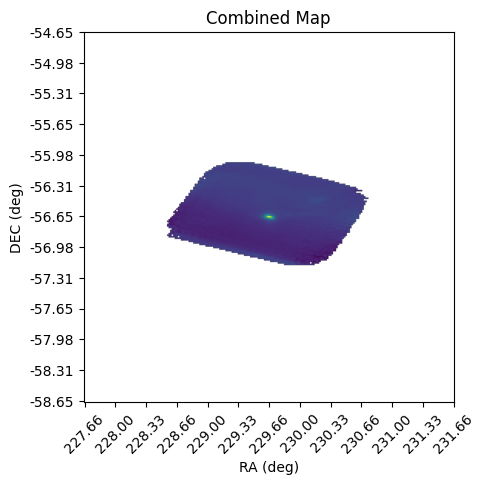

In [8]:
binner0.plot()

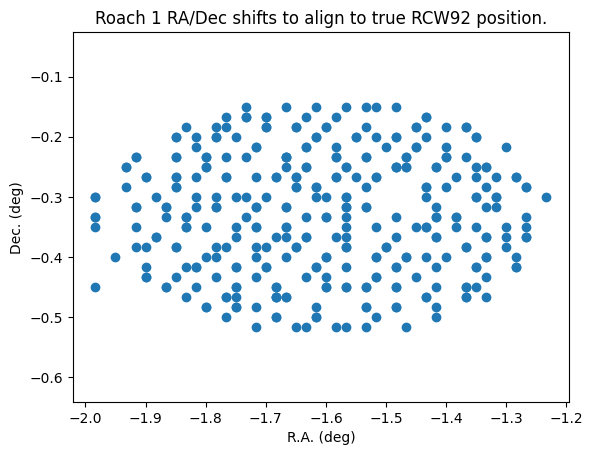

In [9]:
radec_shifts = binner0._kid_shifts
kids = np.array(binner0.calframe["cal_lamp_df"].names)
x_offsets = np.array([radec_shifts[kid][0] for kid in kids])
y_offsets = np.array([radec_shifts[kid][1] for kid in kids])
plt.scatter(x_offsets / gu.deg, y_offsets / gu.deg)
plt.xlabel("R.A. (deg)")
plt.ylabel("Dec. (deg)")
plt.title("Roach 1 RA/Dec shifts to align to true RCW92 position.")
plt.axis("equal")
plt.show()

In [10]:
map_args['ra0']/gu.deg - 228.16

np.float64(1.5029200000000174)

In [11]:
map_args['dec0']/gu.deg - -58.2

np.float64(1.553060000000002)